# 3W dataset's General Presentation

This is a general presentation of the 3W dataset, to the best of its authors' knowledge, the first realistic and public dataset with rare undesirable real events in oil wells that can be readily used as a benchmark dataset for development of machine learning techniques related to inherent difficulties of actual data.

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook presents the 3W dataset in a general way. For this, some tables, graphs, and statistics are presented.

# 2. Imports and Configurations

In [1]:
import sys
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import tensorflow as tf
#NUM_PARALLEL_EXEC_UNITS = 6
#config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = NUM_PARALLEL_EXEC_UNITS, 
#         inter_op_parallelism_threads = 1, 
#         allow_soft_placement = True, 
#         device_count = {'CPU': NUM_PARALLEL_EXEC_UNITS })
#session = tf.compat.v1.Session(config=config)
#tf.compat.v1.keras.backend.set_session(session)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from util_3WT import d3w, CustomDataGen

import pickle
import bisect
import sklearn
import sklearn.model_selection
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4132666557891900372
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1422540800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13611297491031944386
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 950, pci bus id: 0000:01:00.0, compute capability: 5.2"
xla_global_id: 416903419
]


# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [3]:
if pathlib.Path('dset.pkl').exists():
  with open('dset.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset.pkl', 'wb') as f:
      pickle.dump(dset, f)

In [10]:
flist0 = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[[0,1,2,3,4,5,6,7,8,101,102,103,104,105,106,107,108]]

train_df, test_df, val_df = dset.split(real=True, simul=True, drawn=True, test_size=0.1, val_size=0.2, sample_n=300)

Instances Train: 213  Test: 30  Validation: 54


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

More information about these variables can be obtained from the following publicly available documents:

* ***Option in Portuguese***: R.E.V. Vargas. Base de dados e benchmarks para prognóstico de anomalias em sistemas de elevação de petróleo. Universidade Federal do Espírito Santo. Doctoral thesis. 2019. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/doctoral_thesis_ricardo_vargas.pdf.
* ***Option in English***: B.G. Carvalho. Evaluating machine learning techniques for detection of flow instability events in offshore oil wells. Universidade Federal do Espírito Santo. Master's degree dissertation. 2021. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/master_degree_dissertation_bruno_carvalho.pdf.

# Preprocessing

The following table shows the amount of instances that compose the 3W dataset, by knowledge source (real, simulated and hand-drawn instances) and by instance label.

In [24]:
class kmodel():
    
    def __init__(self, name, class_model, features, label, categories, batch_size, seq_length, 
                 train_df, val_df, test_df, tmp_path, reset_ts=False, verbose=1, class_bal=False):
        self.features = features
        self.n_features = len(features)
        self.label = label
        self.categories = categories
        self.n_classes = len(*categories)
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.tmp_path = pathlib.Path(tmp_path)
        self.verbose = verbose
        self.class_bal = class_bal
        self.history = None
        self.class_rep_val = None
        self.class_rep_test = None
        self.class_rep_full = None
        self.conf_mat_val = None
        self.conf_mat_test = None
        self.conf_mat_full = None
        
        self.train = CustomDataGen(train_df, self.features, self.label, categories, 
                                   self.batch_size, self.seq_length, self.tmp_path)
        self.val = CustomDataGen(val_df, self.features, self.label, categories, 
                                 self.batch_size, self.seq_length, self.tmp_path)
        self.test = CustomDataGen(test_df, self.features, self.label, categories, 
                                  self.batch_size, self.seq_length, self.tmp_path)
        self.full = CustomDataGen(pd.concat([train_df, val_df, test_df], ignore_index=True), 
                                  self.features, self.label, categories, 
                                  self.batch_size, self.seq_length, self.tmp_path)
        
        if reset_ts:
            self.full.reset_ts()

        self.model = class_model()
        self.model.build(input_shape=(None, self.seq_length, 2*self.n_features))

        input = tf.keras.Input(shape=(self.seq_length, 2*self.n_features), name='input',
                              tensor=tf.zeros(shape=(self.batch_size, self.seq_length, 2*self.n_features)))
        y = self.model.call(input, training=True)
        
        #for layer in self.model.layers:
        #    print(self.model.name, layer.name, layer.input_shape, '->', layer.output_shape)
        #print('\n')
            
        if self.verbose > 0:
            print(self.model.summary())
        
        return
        
    def compile_and_fit(self, max_epochs=20, patience=3, lr=0.001):

        if self.class_bal:
            y_real = self.train.get_y()
            d = dict(zip(np.unique(y_real), compute_class_weight('balanced', classes=np.unique(y_real), y=y_real)))
            w = dict()
            for i, j in enumerate(categories[0]):
                if j in d.keys():
                    w[i] = d[j]
                else:
                    w[i] = 1.0
        else:
            w = None

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score',
                                                        patience=patience,
                                                        mode='max')

        checkpoint_filepath = self.tmp_path.joinpath('checkpoint')
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_f1_score',
            mode='max',
            save_best_only=True)

        f1_score = tfa.metrics.F1Score(num_classes=self.n_classes, average='macro', threshold=0.5)

        self.model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                           metrics=[tf.keras.metrics.CategoricalAccuracy(), 
                                    tf.keras.metrics.Precision(),
                                    tf.keras.metrics.Recall(),
                                    f1_score])

        self.history = self.model.fit(self.train, epochs=max_epochs,
                                      validation_data=self.val, class_weight=w,
                                      callbacks=[early_stopping, model_checkpoint_callback])

        self.model.load_weights(checkpoint_filepath)
       
        self.class_rep_val, self.conf_mat_val = self.class_rep(self.val)
        
        self.class_rep_test, self.conf_mat_test = self.class_rep(self.test)

        self.class_rep_full, self.conf_mat_full = self.class_rep(self.full)

        if self.verbose > 0:
            self.plot_fithist('f1_score')
            
            self.print_class_rep(self.class_rep_val, 'Val Classification Report')
            self.plot_confusion_matrix(self.conf_mat_val, title='Confusion Matrix Val')
            
            self.print_class_rep(self.class_rep_test, 'Test Classification Report')
            self.plot_confusion_matrix(self.conf_mat_test, title='Confusion Matrix Test')

            self.print_class_rep(self.class_rep_full, 'All Data Classification Report')
            self.plot_confusion_matrix(self.conf_mat_full, title='Confusion Matrix Full')

        return

    # Plot training loss & metric 
    def plot_fithist(self, met):
        N = len(self.history.history['loss'])
        plt.style.use("ggplot")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        fig.suptitle('Training Loss & '+met)

        ax1.plot(np.arange(0, N), self.history.history[met], label="train")
        ax1.plot(np.arange(0, N), self.history.history["val_"+met], label="val")
        ax1.set_title(met)
        ax1.set_xlabel("Epoch #")
        ax1.xaxis.get_major_locator().set_params(integer=True)
        ax1.set_ylabel(met)
        ax1.legend(loc="lower right")

        ax2.plot(np.arange(0, N), self.history.history["loss"], label="train")
        ax2.plot(np.arange(0, N), self.history.history["val_loss"], label="val")
        ax2.set_title("Loss")
        ax2.set_xlabel("Epoch #")
        ax2.xaxis.get_major_locator().set_params(integer=True)
        ax2.set_ylabel("Loss")
        ax2.legend(loc="upper right")

        plt.show()
        return
        
    def save(self):
        filename = self.model.name + '_' +\
            'batch_size_' + str(self.batch_size) + '-' +\
            'seq_length_' + str(self.seq_length) + '-' +\
            str(np.datetime64('now')) + '.h5'
        filename = filename.replace(':', '_')
        self.model.save_weights(filename)
        print('model weights saved in ' + filename)
        return
    
    def class_rep(self, dset):

        pred = self.model.predict(dset)

        y_pred = [self.categories[0][i] for i in np.argmax(pred, axis=1)]
        y_real = dset.get_y()

        return classification_report(y_real, y_pred, zero_division=0, output_dict=True),\
                                             confusion_matrix(y_real, y_pred, labels=self.categories[0])
    
    def print_class_rep(self, data_dict, title):
        # extracted from: https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/metrics/_classification.py#L1825
        """Build a text report showing the main classification metrics.
        Read more in the :ref:`User Guide <classification_report>`.
        Parameters
        ----------
        report : string
            Text summary of the precision, recall, F1 score for each class.
            Dictionary returned if output_dict is True. Dictionary has the
            following structure::
                {'label 1': {'precision':0.5,
                             'recall':1.0,
                             'f1-score':0.67,
                             'support':1},
                 'label 2': { ... },
                  ...
                }
            The reported averages include macro average (averaging the unweighted
            mean per label), weighted average (averaging the support-weighted mean
            per label), and sample average (only for multilabel classification).
            Micro average (averaging the total true positives, false negatives and
            false positives) is only shown for multi-label or multi-class
            with a subset of classes, because it corresponds to accuracy otherwise.
            See also :func:`precision_recall_fscore_support` for more details
            on averages.
            Note that in binary classification, recall of the positive class
            is also known as "sensitivity"; recall of the negative class is
            "specificity".
        """

        non_label_keys = ["accuracy", "macro avg", "weighted avg"]
        y_type = "binary"
        digits = 2

        target_names = [
            "%s" % key for key in data_dict.keys() if key not in non_label_keys
        ]

        # labelled micro average
        micro_is_accuracy = (y_type == "multiclass" or y_type == "binary")

        headers = ["precision", "recall", "f1-score", "support"]
        p = [data_dict[l][headers[0]] for l in target_names]
        r = [data_dict[l][headers[1]] for l in target_names]
        f1 = [data_dict[l][headers[2]] for l in target_names]
        s = [data_dict[l][headers[3]] for l in target_names]

        rows = zip(target_names, p, r, f1, s)

        if y_type.startswith("multilabel"):
            average_options = ("micro", "macro", "weighted", "samples")
        else:
            average_options = ("micro", "macro", "weighted")

        longest_last_line_heading = "weighted avg"
        name_width = max(len(cn) for cn in target_names)
        width = max(name_width, len(longest_last_line_heading), digits)
        head_fmt = "{:>{width}s} " + " {:>9}" * len(headers)
        report = head_fmt.format("", *headers, width=width)
        report += "\n\n"
        row_fmt = "{:>{width}s} " + " {:>9.{digits}f}" * 3 + " {:>9}\n"
        for row in rows:
            report += row_fmt.format(*row, width=width, digits=digits)
        report += "\n"

        # compute all applicable averages
        for average in average_options:
            if average.startswith("micro") and micro_is_accuracy:
                line_heading = "accuracy"
            else:
                line_heading = average + " avg"

            if line_heading == "accuracy":
                avg = [data_dict[line_heading], sum(s)]
                row_fmt_accuracy = "{:>{width}s} " + \
                        " {:>9.{digits}}" * 2 + " {:>9.{digits}f}" + \
                        " {:>9}\n"
                report += row_fmt_accuracy.format(line_heading, "", "",
                                                  *avg, width=width,
                                                  digits=digits)
            else:
                avg = list(data_dict[line_heading].values())
                report += row_fmt.format(line_heading, *avg,
                                         width=width, digits=digits)
        print(title)
        print(report)
        
        return

    def plot_confusion_matrix(self, cm, title='Confusion Matrix'):
        con = np.zeros((self.n_classes, self.n_classes))
        for x in range(self.n_classes):
            for y in range(self.n_classes):
                if np.sum(cm[x,:]) > 0:
                    con[x,y] = cm[x,y]/np.sum(cm[x,:])

        plt.figure(figsize=(10,6))
        sns.set(font_scale=0.75) # for label size
        ax = sns.heatmap(con, annot=True,fmt='.3f', cmap='Blues',xticklabels= self.categories[0] , 
                         yticklabels= self.categories[0], cbar=False)
        plt.tight_layout()
        ax.set_xlabel('Predicted', fontsize=16)
        ax.set_ylabel('Real', fontsize=16)
        ax.set_title(title, fontsize=18)
        plt.show()

In [12]:
class kmodel_from_file(kmodel):
    def __init__(self, model, input_shape, filename):

        self.model = model()
        self.model.build(input_shape=(None,)+input_shape)
        self.model.load_weights(filename)
        self.model.summary()
        
    def class_rep(self, dset):
        self.categories = dset.categories
        self.n_classes = len(*self.categories)
        cr, cm = super().class_rep(dset)
        super().print_class_rep(cr, 'Classification Report')
        super().plot_confusion_matrix(cm, title='Confusion Matrix')
        return

In [13]:
class param_fit():
    def __init__(self, name, class_model, features, label, categories, batch_sizes, seq_lengths, learning_rates, 
                 train_df, test_df, tmp_path):
        self.name = name 
        self.class_model = class_model
        self.features = features
        self.label = label
        self.categories = categories
        self.batch_sizes = batch_sizes
        self.seq_lengths = seq_lengths
        self.learning_rates = learning_rates
        self.train_df = train_df
        self.test_df = test_df
        self.tmp_path = tmp_path
        self.report = dict()
        return
    
    def fit(self, n_splits=5, max_epochs=50, patience=3):
        kf = sklearn.model_selection.StratifiedKFold(n_splits=n_splits)
        
        self.report['batch_size'] = []
        self.report['seq_length'] = []
        self.report['learning_rate'] = []
        self.report['cv_n'] = []
        self.report['class_rep_val'] = []
        self.report['class_rep_test'] = []
        for batch_size in self.batch_sizes:
            breset = True
            for seq_length in self.seq_lengths:
                breset = True
                for learning_rate in self.learning_rates:
                    for i, (train_index, val_index) in enumerate(kf.split(self.train_df, self.train_df['label'])):
                        print('\n', i, batch_size, seq_length, learning_rate,
                              len(train_index), len(val_index), '\n')
                        model = kmodel(self.name, self.class_model, self.features, self.label, self.categories, 
                                   batch_size, seq_length, 
                                   self.train_df.iloc[train_index].reset_index(drop=True), 
                                   self.train_df.iloc[val_index].reset_index(drop=True), 
                                   self.test_df, 
                                   'D:/datatmp', reset_ts=breset, verbose=0)
                        model.compile_and_fit(max_epochs=max_epochs, patience=patience, lr=learning_rate)
                        breset = False
                        self.report['batch_size'].append(batch_size)
                        self.report['seq_length'].append(seq_length)
                        self.report['learning_rate'].append(learning_rate)
                        self.report['cv_n'].append(i)
                        self.report['class_rep_val'].append(model.class_rep_val)
                        self.report['class_rep_test'].append(model.class_rep_test)
                        
        
        rep_df = pd.DataFrame(self.report)
        rep_df['val_accuracy'] = rep_df.class_rep_val.apply(pd.Series)['accuracy']
        rep_df['val_precision'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['precision']
        rep_df['val_recall'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['recall']
        rep_df['val_f1_score'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['f1-score']
        rep_df.drop(['class_rep_val', 'class_rep_test'], axis=1, inplace=True)
        
        fdict = {'val_accuracy': ['mean', 'std'], 'val_precision': ['mean', 'std'],
                 'val_recall': ['mean', 'std'], 'val_f1_score': ['mean', 'std']}
        display(rep_df.groupby(['batch_size', 'seq_length', 'learning_rate']).agg(fdict))        
        
        filename = self.name + '_report_' +\
            str(np.datetime64('now')) + '.pkl'
        filename = filename.replace(':', '_')

        with open(filename, 'wb') as f:
            pickle.dump(self.report, f)



# Linear model

In [22]:
class LinearModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.flatten = layers.Flatten()
    self.norm = layers.LayerNormalization()
    self.dense = layers.Dense(units=17, activation='sigmoid')

  def call(self, inputs, training=False):
    x = self.flatten(inputs)
    x = self.norm(x)
    return self.dense(x)

In [26]:
%%time

train_df, test_df = dset.split(real=True, simul=True, drawn=True, test_size=0.2, val_size=0, sample_n=300)

tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

linear_param_fit = param_fit('linear_param_fit', LinearModel, flist0, 'class', categories, 
                             [32, 64], [15, 30], [0.0001, 0.001], 
                             train_df, test_df, 'D:/datatmp')
linear_param_fit.fit(n_splits=5, max_epochs=50)

Instances Train: 237  Test: 60

 0 32 15 0.0001 189 48 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Epoch 1/50
2636/2636 [==============================] - 67s 25ms/step - loss: 2.3815 - categorical_accuracy: 0.3326 - precision: 0.0927 - recall: 0.7150 - f1_score: 0.1292 - val_loss: 2.0120 - val_categorical_accuracy: 0.4345 - val_precision: 0.1036 - val_recall: 0.7958 - val_f1_score: 0.1330
Epoch 2/50
2636/2636 [==============================] - 38s 14ms/step - loss: 1.7201 - categorical_accuracy: 0.4939 - precision: 0.1155 - recall: 0.8580 - f1_score: 0.1466 - val_loss: 1.7653 - val_categorical_accuracy: 0.4907 - val_precision: 0.1170 - val_recall: 0.8440 - val_f1_score: 0.1369
Epoch 3/50
2636/2636 [==============================] - 37s 14ms/step - loss: 1.5257 - categorical_accuracy: 0.5473 - precision: 0.1237 - recall: 0.8933 - f1_score: 0.1528 - val_loss: 1.6732 - val_categorical_accuracy: 0.5202 - val_precision: 0.1208 - val_recall: 0.8710 - val_f1_score: 0.1424
Epoch 4/50
2636/2636 [==============================] - 37s 14ms/step - loss: 1.4371 - categorical_accuracy: 0.5720 - 

2643/2643 [==============================] - 39s 15ms/step - loss: 1.3049 - categorical_accuracy: 0.6155 - precision_1: 0.1316 - recall_1: 0.9433 - f1_score: 0.2004 - val_loss: 1.3461 - val_categorical_accuracy: 0.5956 - val_precision_1: 0.1330 - val_recall_1: 0.9479 - val_f1_score: 0.1996
Epoch 13/50
2643/2643 [==============================] - 38s 14ms/step - loss: 1.2993 - categorical_accuracy: 0.6191 - precision_1: 0.1316 - recall_1: 0.9450 - f1_score: 0.2107 - val_loss: 1.3434 - val_categorical_accuracy: 0.5985 - val_precision_1: 0.1324 - val_recall_1: 0.9470 - val_f1_score: 0.1965
Epoch 14/50
2643/2643 [==============================] - 39s 15ms/step - loss: 1.2939 - categorical_accuracy: 0.6196 - precision_1: 0.1315 - recall_1: 0.9465 - f1_score: 0.2120 - val_loss: 1.3467 - val_categorical_accuracy: 0.5970 - val_precision_1: 0.1321 - val_recall_1: 0.9447 - val_f1_score: 0.1967
Epoch 15/50
2643/2643 [==============================] - 39s 15ms/step - loss: 1.2904 - categorical_acc

Epoch 12/50
2678/2678 [==============================] - 36s 14ms/step - loss: 1.3026 - categorical_accuracy: 0.6145 - precision_3: 0.1305 - recall_3: 0.9549 - f1_score: 0.2041 - val_loss: 1.3720 - val_categorical_accuracy: 0.6102 - val_precision_3: 0.1286 - val_recall_3: 0.9394 - val_f1_score: 0.1826
Epoch 13/50
2678/2678 [==============================] - 36s 13ms/step - loss: 1.2975 - categorical_accuracy: 0.6105 - precision_3: 0.1304 - recall_3: 0.9559 - f1_score: 0.2057 - val_loss: 1.3590 - val_categorical_accuracy: 0.6209 - val_precision_3: 0.1282 - val_recall_3: 0.9396 - val_f1_score: 0.1824
Epoch 14/50
2678/2678 [==============================] - 39s 14ms/step - loss: 1.2923 - categorical_accuracy: 0.6169 - precision_3: 0.1299 - recall_3: 0.9567 - f1_score: 0.2068 - val_loss: 1.3622 - val_categorical_accuracy: 0.6148 - val_precision_3: 0.1289 - val_recall_3: 0.9401 - val_f1_score: 0.1845
Epoch 15/50
2678/2678 [==============================] - 36s 13ms/step - loss: 1.2877 - cat

Epoch 17/50
2679/2679 [==============================] - 37s 14ms/step - loss: 1.2981 - categorical_accuracy: 0.6183 - precision_4: 0.1340 - recall_4: 0.9544 - f1_score: 0.2301 - val_loss: 1.2904 - val_categorical_accuracy: 0.6200 - val_precision_4: 0.1336 - val_recall_4: 0.9502 - val_f1_score: 0.1872

 0 32 15 0.001 189 48 

Epoch 1/50


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


2636/2636 [==============================] - 42s 16ms/step - loss: 1.6167 - categorical_accuracy: 0.5376 - precision_5: 0.1241 - recall_5: 0.8977 - f1_score: 0.1576 - val_loss: 1.5686 - val_categorical_accuracy: 0.5692 - val_precision_5: 0.1290 - val_recall_5: 0.9283 - val_f1_score: 0.1594
Epoch 2/50
2636/2636 [==============================] - 39s 15ms/step - loss: 1.3654 - categorical_accuracy: 0.5945 - precision_5: 0.1290 - recall_5: 0.9491 - f1_score: 0.1813 - val_loss: 1.5518 - val_categorical_accuracy: 0.5455 - val_precision_5: 0.1230 - val_recall_5: 0.9326 - val_f1_score: 0.1675
Epoch 3/50
2636/2636 [==============================] - 40s 15ms/step - loss: 1.3211 - categorical_accuracy: 0.6177 - precision_5: 0.1284 - recall_5: 0.9554 - f1_score: 0.1901 - val_loss: 1.6260 - val_categorical_accuracy: 0.5621 - val_precision_5: 0.1239 - val_recall_5: 0.9286 - val_f1_score: 0.1765
Epoch 4/50
2636/2636 [==============================] - 37s 14ms/step - loss: 1.3152 - categorical_accura

Epoch 13/50
2512/2512 [==============================] - 38s 15ms/step - loss: 1.2517 - categorical_accuracy: 0.6364 - precision_7: 0.1381 - recall_7: 0.9481 - f1_score: 0.2405 - val_loss: 2.3580 - val_categorical_accuracy: 0.4568 - val_precision_7: 0.1239 - val_recall_7: 0.8737 - val_f1_score: 0.1670
Epoch 14/50
2512/2512 [==============================] - 38s 15ms/step - loss: 1.2578 - categorical_accuracy: 0.6328 - precision_7: 0.1385 - recall_7: 0.9484 - f1_score: 0.2423 - val_loss: 2.4306 - val_categorical_accuracy: 0.4771 - val_precision_7: 0.1264 - val_recall_7: 0.8778 - val_f1_score: 0.1685
Epoch 15/50
2512/2512 [==============================] - 38s 15ms/step - loss: 1.2458 - categorical_accuracy: 0.6374 - precision_7: 0.1401 - recall_7: 0.9481 - f1_score: 0.2442 - val_loss: 2.4108 - val_categorical_accuracy: 0.4762 - val_precision_7: 0.1251 - val_recall_7: 0.8668 - val_f1_score: 0.1689

 3 32 15 0.001 190 47 

Epoch 1/50
2678/2678 [==============================] - 39s 14ms/s

Epoch 10/50
2679/2679 [==============================] - 38s 14ms/step - loss: 1.3051 - categorical_accuracy: 0.6152 - precision_9: 0.1372 - recall_9: 0.9512 - f1_score: 0.2584 - val_loss: 1.2731 - val_categorical_accuracy: 0.6247 - val_precision_9: 0.1376 - val_recall_9: 0.9524 - val_f1_score: 0.2089
Epoch 11/50
2679/2679 [==============================] - 38s 14ms/step - loss: 1.3026 - categorical_accuracy: 0.6143 - precision_9: 0.1372 - recall_9: 0.9459 - f1_score: 0.2607 - val_loss: 1.2847 - val_categorical_accuracy: 0.6625 - val_precision_9: 0.1389 - val_recall_9: 0.9447 - val_f1_score: 0.2080
Epoch 12/50
2679/2679 [==============================] - 38s 14ms/step - loss: 1.2917 - categorical_accuracy: 0.6248 - precision_9: 0.1380 - recall_9: 0.9444 - f1_score: 0.2482 - val_loss: 1.2855 - val_categorical_accuracy: 0.6687 - val_precision_9: 0.1403 - val_recall_9: 0.9480 - val_f1_score: 0.2107
Epoch 13/50
2679/2679 [==============================] - 38s 14ms/step - loss: 1.2995 - cat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



 0 32 30 0.0001 189 48 

Epoch 1/50
2584/2584 [==============================] - 72s 27ms/step - loss: 2.1609 - categorical_accuracy: 0.3926 - precision_10: 0.1043 - recall_10: 0.7741 - f1_score: 0.1456 - val_loss: 1.9377 - val_categorical_accuracy: 0.4388 - val_precision_10: 0.1139 - val_recall_10: 0.8315 - val_f1_score: 0.1411
Epoch 2/50
2584/2584 [==============================] - 41s 16ms/step - loss: 1.5966 - categorical_accuracy: 0.5307 - precision_10: 0.1270 - recall_10: 0.8803 - f1_score: 0.1594 - val_loss: 1.7016 - val_categorical_accuracy: 0.4890 - val_precision_10: 0.1276 - val_recall_10: 0.8881 - val_f1_score: 0.1533
Epoch 3/50
2584/2584 [==============================] - 43s 16ms/step - loss: 1.4295 - categorical_accuracy: 0.5676 - precision_10: 0.1335 - recall_10: 0.9166 - f1_score: 0.1682 - val_loss: 1.6125 - val_categorical_accuracy: 0.5074 - val_precision_10: 0.1290 - val_recall_10: 0.9097 - val_f1_score: 0.1595
Epoch 4/50
2584/2584 [==============================] - 

2595/2595 [==============================] - 41s 16ms/step - loss: 1.2256 - categorical_accuracy: 0.6237 - precision_11: 0.1353 - recall_11: 0.9562 - f1_score: 0.2411 - val_loss: 1.3034 - val_categorical_accuracy: 0.5965 - val_precision_11: 0.1348 - val_recall_11: 0.9546 - val_f1_score: 0.1973
Epoch 16/50
2595/2595 [==============================] - 41s 16ms/step - loss: 1.2173 - categorical_accuracy: 0.6312 - precision_11: 0.1345 - recall_11: 0.9553 - f1_score: 0.2425 - val_loss: 1.3094 - val_categorical_accuracy: 0.5970 - val_precision_11: 0.1350 - val_recall_11: 0.9555 - val_f1_score: 0.2012
Epoch 17/50
2595/2595 [==============================] - 41s 16ms/step - loss: 1.2180 - categorical_accuracy: 0.6295 - precision_11: 0.1338 - recall_11: 0.9557 - f1_score: 0.2392 - val_loss: 1.2952 - val_categorical_accuracy: 0.6124 - val_precision_11: 0.1369 - val_recall_11: 0.9618 - val_f1_score: 0.2050
Epoch 18/50
2595/2595 [==============================] - 41s 16ms/step - loss: 1.2146 - cat


 3 32 30 0.0001 190 47 

Epoch 1/50
2627/2627 [==============================] - 43s 16ms/step - loss: 2.1257 - categorical_accuracy: 0.4160 - precision_13: 0.1072 - recall_13: 0.7821 - f1_score: 0.1490 - val_loss: 1.7528 - val_categorical_accuracy: 0.5236 - val_precision_13: 0.1207 - val_recall_13: 0.8439 - val_f1_score: 0.1521
Epoch 2/50
2627/2627 [==============================] - 41s 16ms/step - loss: 1.6143 - categorical_accuracy: 0.5359 - precision_13: 0.1272 - recall_13: 0.8772 - f1_score: 0.1609 - val_loss: 1.5304 - val_categorical_accuracy: 0.5660 - val_precision_13: 0.1341 - val_recall_13: 0.8963 - val_f1_score: 0.1615
Epoch 3/50
2627/2627 [==============================] - 41s 16ms/step - loss: 1.4544 - categorical_accuracy: 0.5697 - precision_13: 0.1343 - recall_13: 0.9146 - f1_score: 0.1712 - val_loss: 1.4320 - val_categorical_accuracy: 0.5830 - val_precision_13: 0.1336 - val_recall_13: 0.9181 - val_f1_score: 0.1697
Epoch 4/50
2627/2627 [==============================] - 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


2584/2584 [==============================] - 42s 16ms/step - loss: 1.6169 - categorical_accuracy: 0.5406 - precision_15: 0.1329 - recall_15: 0.8979 - f1_score: 0.1701 - val_loss: 1.5946 - val_categorical_accuracy: 0.5549 - val_precision_15: 0.1326 - val_recall_15: 0.9290 - val_f1_score: 0.1893
Epoch 2/50
2584/2584 [==============================] - 40s 16ms/step - loss: 1.3807 - categorical_accuracy: 0.5882 - precision_15: 0.1363 - recall_15: 0.9530 - f1_score: 0.1983 - val_loss: 1.5753 - val_categorical_accuracy: 0.5482 - val_precision_15: 0.1321 - val_recall_15: 0.9336 - val_f1_score: 0.1880
Epoch 3/50
2584/2584 [==============================] - 41s 16ms/step - loss: 1.3191 - categorical_accuracy: 0.6049 - precision_15: 0.1340 - recall_15: 0.9572 - f1_score: 0.2008 - val_loss: 1.5953 - val_categorical_accuracy: 0.5349 - val_precision_15: 0.1293 - val_recall_15: 0.9399 - val_f1_score: 0.1904
Epoch 4/50
2584/2584 [==============================] - 41s 16ms/step - loss: 1.3012 - catego

Epoch 4/50
2461/2461 [==============================] - 42s 17ms/step - loss: 1.2917 - categorical_accuracy: 0.6034 - precision_17: 0.1344 - recall_17: 0.9544 - f1_score: 0.2001 - val_loss: 2.2971 - val_categorical_accuracy: 0.4337 - val_precision_17: 0.1209 - val_recall_17: 0.8583 - val_f1_score: 0.1629
Epoch 5/50
2461/2461 [==============================] - 42s 17ms/step - loss: 1.2801 - categorical_accuracy: 0.6029 - precision_17: 0.1347 - recall_17: 0.9530 - f1_score: 0.2079 - val_loss: 2.2046 - val_categorical_accuracy: 0.4346 - val_precision_17: 0.1217 - val_recall_17: 0.8913 - val_f1_score: 0.1608

 3 32 30 0.001 190 47 

Epoch 1/50
2627/2627 [==============================] - 38s 14ms/step - loss: 1.6274 - categorical_accuracy: 0.5281 - precision_18: 0.1296 - recall_18: 0.9108 - f1_score: 0.1693 - val_loss: 1.4805 - val_categorical_accuracy: 0.5621 - val_precision_18: 0.1321 - val_recall_18: 0.9371 - val_f1_score: 0.1800
Epoch 2/50
2627/2627 [==============================] - 4

Epoch 26/50
2627/2627 [==============================] - 47s 18ms/step - loss: 1.2068 - categorical_accuracy: 0.6319 - precision_18: 0.1546 - recall_18: 0.9466 - f1_score: 0.3088 - val_loss: 1.3771 - val_categorical_accuracy: 0.5661 - val_precision_18: 0.1536 - val_recall_18: 0.9296 - val_f1_score: 0.2535
Epoch 27/50
2627/2627 [==============================] - 46s 18ms/step - loss: 1.2074 - categorical_accuracy: 0.6348 - precision_18: 0.1558 - recall_18: 0.9411 - f1_score: 0.3077 - val_loss: 1.2724 - val_categorical_accuracy: 0.6410 - val_precision_18: 0.1489 - val_recall_18: 0.9140 - val_f1_score: 0.2351
Epoch 28/50
2627/2627 [==============================] - 45s 17ms/step - loss: 1.2041 - categorical_accuracy: 0.6333 - precision_18: 0.1549 - recall_18: 0.9438 - f1_score: 0.3100 - val_loss: 1.2908 - val_categorical_accuracy: 0.6149 - val_precision_18: 0.1533 - val_recall_18: 0.9117 - val_f1_score: 0.2297
Epoch 29/50
2627/2627 [==============================] - 38s 14ms/step - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



 0 64 15 0.0001 189 48 

Epoch 1/50
1367/1367 [==============================] - 46s 33ms/step - loss: 2.5924 - categorical_accuracy: 0.2929 - precision_20: 0.0877 - recall_20: 0.6630 - f1_score: 0.1285 - val_loss: 2.3139 - val_categorical_accuracy: 0.3560 - val_precision_20: 0.0988 - val_recall_20: 0.7370 - val_f1_score: 0.1348
Epoch 2/50
1367/1367 [==============================] - 18s 13ms/step - loss: 1.9849 - categorical_accuracy: 0.4160 - precision_20: 0.1113 - recall_20: 0.8079 - f1_score: 0.1506 - val_loss: 2.0233 - val_categorical_accuracy: 0.4336 - val_precision_20: 0.1110 - val_recall_20: 0.8030 - val_f1_score: 0.1411
Epoch 3/50
1367/1367 [==============================] - 18s 13ms/step - loss: 1.7452 - categorical_accuracy: 0.4860 - precision_20: 0.1226 - recall_20: 0.8550 - f1_score: 0.1580 - val_loss: 1.8553 - val_categorical_accuracy: 0.4747 - val_precision_20: 0.1212 - val_recall_20: 0.8446 - val_f1_score: 0.1474
Epoch 4/50
1367/1367 [==============================] - 

1371/1371 [==============================] - 19s 13ms/step - loss: 2.4716 - categorical_accuracy: 0.3253 - precision_21: 0.0916 - recall_21: 0.7281 - f1_score: 0.1344 - val_loss: 2.1138 - val_categorical_accuracy: 0.4188 - val_precision_21: 0.0964 - val_recall_21: 0.7630 - val_f1_score: 0.1371
Epoch 2/50
1371/1371 [==============================] - 18s 13ms/step - loss: 1.9719 - categorical_accuracy: 0.4451 - precision_21: 0.1075 - recall_21: 0.8107 - f1_score: 0.1473 - val_loss: 1.8813 - val_categorical_accuracy: 0.4458 - val_precision_21: 0.1068 - val_recall_21: 0.8036 - val_f1_score: 0.1422
Epoch 3/50
1371/1371 [==============================] - 18s 13ms/step - loss: 1.7681 - categorical_accuracy: 0.4830 - precision_21: 0.1189 - recall_21: 0.8565 - f1_score: 0.1539 - val_loss: 1.7289 - val_categorical_accuracy: 0.4710 - val_precision_21: 0.1171 - val_recall_21: 0.8545 - val_f1_score: 0.1491
Epoch 4/50
1371/1371 [==============================] - 18s 13ms/step - loss: 1.6340 - catego

Epoch 6/50
1304/1304 [==============================] - 15s 12ms/step - loss: 1.4469 - categorical_accuracy: 0.5795 - precision_22: 0.1427 - recall_22: 0.9120 - f1_score: 0.1635 - val_loss: 2.0530 - val_categorical_accuracy: 0.4451 - val_precision_22: 0.1265 - val_recall_22: 0.8214 - val_f1_score: 0.1512
Epoch 7/50
1304/1304 [==============================] - 15s 11ms/step - loss: 1.4089 - categorical_accuracy: 0.5848 - precision_22: 0.1438 - recall_22: 0.9179 - f1_score: 0.1684 - val_loss: 2.0430 - val_categorical_accuracy: 0.4561 - val_precision_22: 0.1270 - val_recall_22: 0.8372 - val_f1_score: 0.1536
Epoch 8/50
1304/1304 [==============================] - 15s 11ms/step - loss: 1.3840 - categorical_accuracy: 0.5855 - precision_22: 0.1419 - recall_22: 0.9268 - f1_score: 0.1716 - val_loss: 2.0567 - val_categorical_accuracy: 0.4577 - val_precision_22: 0.1275 - val_recall_22: 0.8484 - val_f1_score: 0.1550
Epoch 9/50
1304/1304 [==============================] - 15s 11ms/step - loss: 1.36

Epoch 17/50
1387/1387 [==============================] - 17s 13ms/step - loss: 1.3206 - categorical_accuracy: 0.5987 - precision_23: 0.1283 - recall_23: 0.9571 - f1_score: 0.1909 - val_loss: 1.3655 - val_categorical_accuracy: 0.6157 - val_precision_23: 0.1262 - val_recall_23: 0.9341 - val_f1_score: 0.1824
Epoch 18/50
1387/1387 [==============================] - 17s 12ms/step - loss: 1.3170 - categorical_accuracy: 0.6048 - precision_23: 0.1282 - recall_23: 0.9592 - f1_score: 0.1923 - val_loss: 1.3635 - val_categorical_accuracy: 0.6174 - val_precision_23: 0.1259 - val_recall_23: 0.9347 - val_f1_score: 0.1835
Epoch 19/50
1387/1387 [==============================] - 17s 13ms/step - loss: 1.3116 - categorical_accuracy: 0.6039 - precision_23: 0.1284 - recall_23: 0.9596 - f1_score: 0.1926 - val_loss: 1.3698 - val_categorical_accuracy: 0.6111 - val_precision_23: 0.1266 - val_recall_23: 0.9352 - val_f1_score: 0.1852
Epoch 20/50
1387/1387 [==============================] - 17s 12ms/step - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


1367/1367 [==============================] - 19s 13ms/step - loss: 1.7370 - categorical_accuracy: 0.4994 - precision_25: 0.1245 - recall_25: 0.8601 - f1_score: 0.1576 - val_loss: 1.6419 - val_categorical_accuracy: 0.5438 - val_precision_25: 0.1282 - val_recall_25: 0.9136 - val_f1_score: 0.1645
Epoch 2/50
1367/1367 [==============================] - 17s 13ms/step - loss: 1.4032 - categorical_accuracy: 0.5844 - precision_25: 0.1306 - recall_25: 0.9371 - f1_score: 0.1783 - val_loss: 1.6448 - val_categorical_accuracy: 0.5102 - val_precision_25: 0.1312 - val_recall_25: 0.9236 - val_f1_score: 0.1712
Epoch 3/50
1367/1367 [==============================] - 18s 13ms/step - loss: 1.3638 - categorical_accuracy: 0.5918 - precision_25: 0.1311 - recall_25: 0.9454 - f1_score: 0.1878 - val_loss: 1.6282 - val_categorical_accuracy: 0.5192 - val_precision_25: 0.1305 - val_recall_25: 0.9319 - val_f1_score: 0.1721
Epoch 4/50
1367/1367 [==============================] - 17s 13ms/step - loss: 1.3382 - catego

1387/1387 [==============================] - 19s 13ms/step - loss: 1.7735 - categorical_accuracy: 0.4939 - precision_28: 0.1216 - recall_28: 0.8582 - f1_score: 0.1547 - val_loss: 1.4852 - val_categorical_accuracy: 0.5848 - val_precision_28: 0.1272 - val_recall_28: 0.9095 - val_f1_score: 0.1648
Epoch 2/50
1387/1387 [==============================] - 18s 13ms/step - loss: 1.4354 - categorical_accuracy: 0.5707 - precision_28: 0.1319 - recall_28: 0.9430 - f1_score: 0.1834 - val_loss: 1.4334 - val_categorical_accuracy: 0.5862 - val_precision_28: 0.1312 - val_recall_28: 0.9329 - val_f1_score: 0.1812
Epoch 3/50
1387/1387 [==============================] - 17s 13ms/step - loss: 1.3804 - categorical_accuracy: 0.5930 - precision_28: 0.1324 - recall_28: 0.9491 - f1_score: 0.2017 - val_loss: 1.4276 - val_categorical_accuracy: 0.5913 - val_precision_28: 0.1305 - val_recall_28: 0.9374 - val_f1_score: 0.1918
Epoch 4/50
1387/1387 [==============================] - 17s 13ms/step - loss: 1.3683 - catego

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



 0 64 30 0.0001 189 48 

Epoch 1/50
1363/1363 [==============================] - 50s 36ms/step - loss: 2.3326 - categorical_accuracy: 0.3649 - precision_30: 0.0965 - recall_30: 0.7332 - f1_score: 0.1388 - val_loss: 2.0713 - val_categorical_accuracy: 0.4302 - val_precision_30: 0.1009 - val_recall_30: 0.8006 - val_f1_score: 0.1394
Epoch 2/50
1363/1363 [==============================] - 20s 15ms/step - loss: 1.7957 - categorical_accuracy: 0.4867 - precision_30: 0.1114 - recall_30: 0.8380 - f1_score: 0.1527 - val_loss: 1.8288 - val_categorical_accuracy: 0.4880 - val_precision_30: 0.1146 - val_recall_30: 0.8499 - val_f1_score: 0.1438
Epoch 3/50
1363/1363 [==============================] - 20s 15ms/step - loss: 1.5923 - categorical_accuracy: 0.5435 - precision_30: 0.1235 - recall_30: 0.8798 - f1_score: 0.1570 - val_loss: 1.7159 - val_categorical_accuracy: 0.5086 - val_precision_30: 0.1231 - val_recall_30: 0.8756 - val_f1_score: 0.1499
Epoch 4/50
1363/1363 [==============================] - 

1367/1367 [==============================] - 17s 12ms/step - loss: 1.3334 - categorical_accuracy: 0.5944 - precision_31: 0.1323 - recall_31: 0.9385 - f1_score: 0.1815 - val_loss: 1.3888 - val_categorical_accuracy: 0.5843 - val_precision_31: 0.1307 - val_recall_31: 0.9344 - val_f1_score: 0.1798
Epoch 10/50
1367/1367 [==============================] - 17s 12ms/step - loss: 1.3173 - categorical_accuracy: 0.5987 - precision_31: 0.1322 - recall_31: 0.9403 - f1_score: 0.1858 - val_loss: 1.3790 - val_categorical_accuracy: 0.5809 - val_precision_31: 0.1306 - val_recall_31: 0.9385 - val_f1_score: 0.1815
Epoch 11/50
1367/1367 [==============================] - 17s 12ms/step - loss: 1.3057 - categorical_accuracy: 0.6014 - precision_31: 0.1321 - recall_31: 0.9433 - f1_score: 0.1859 - val_loss: 1.3644 - val_categorical_accuracy: 0.5740 - val_precision_31: 0.1314 - val_recall_31: 0.9427 - val_f1_score: 0.1838
Epoch 12/50
1367/1367 [==============================] - 17s 13ms/step - loss: 1.2942 - cat

Epoch 7/50
1302/1302 [==============================] - 16s 12ms/step - loss: 1.3399 - categorical_accuracy: 0.5843 - precision_32: 0.1325 - recall_32: 0.9379 - f1_score: 0.1715 - val_loss: 2.0300 - val_categorical_accuracy: 0.4485 - val_precision_32: 0.1181 - val_recall_32: 0.8643 - val_f1_score: 0.1468
Epoch 8/50
1302/1302 [==============================] - 17s 13ms/step - loss: 1.3133 - categorical_accuracy: 0.5942 - precision_32: 0.1310 - recall_32: 0.9428 - f1_score: 0.1744 - val_loss: 2.0640 - val_categorical_accuracy: 0.4451 - val_precision_32: 0.1185 - val_recall_32: 0.8731 - val_f1_score: 0.1477

 3 64 30 0.0001 190 47 

Epoch 1/50
1384/1384 [==============================] - 19s 13ms/step - loss: 2.4260 - categorical_accuracy: 0.3423 - precision_33: 0.0961 - recall_33: 0.7239 - f1_score: 0.1364 - val_loss: 1.9432 - val_categorical_accuracy: 0.4649 - val_precision_33: 0.1142 - val_recall_33: 0.8168 - val_f1_score: 0.1479
Epoch 2/50
1384/1384 [==============================] - 

1384/1384 [==============================] - 16s 12ms/step - loss: 1.6363 - categorical_accuracy: 0.5315 - precision_34: 0.1258 - recall_34: 0.8884 - f1_score: 0.1618 - val_loss: 1.5029 - val_categorical_accuracy: 0.5565 - val_precision_34: 0.1350 - val_recall_34: 0.9154 - val_f1_score: 0.1609
Epoch 4/50
1384/1384 [==============================] - 16s 12ms/step - loss: 1.5185 - categorical_accuracy: 0.5514 - precision_34: 0.1320 - recall_34: 0.9121 - f1_score: 0.1672 - val_loss: 1.4254 - val_categorical_accuracy: 0.5802 - val_precision_34: 0.1374 - val_recall_34: 0.9280 - val_f1_score: 0.1687
Epoch 5/50
1384/1384 [==============================] - 16s 11ms/step - loss: 1.4551 - categorical_accuracy: 0.5689 - precision_34: 0.1343 - recall_34: 0.9250 - f1_score: 0.1743 - val_loss: 1.3807 - val_categorical_accuracy: 0.5853 - val_precision_34: 0.1341 - val_recall_34: 0.9352 - val_f1_score: 0.1664
Epoch 6/50
1384/1384 [==============================] - 26s 19ms/step - loss: 1.4087 - catego

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


1363/1363 [==============================] - 18s 12ms/step - loss: 1.7114 - categorical_accuracy: 0.5182 - precision_35: 0.1278 - recall_35: 0.8797 - f1_score: 0.1621 - val_loss: 1.6433 - val_categorical_accuracy: 0.5247 - val_precision_35: 0.1319 - val_recall_35: 0.9209 - val_f1_score: 0.1660
Epoch 2/50
1363/1363 [==============================] - 16s 12ms/step - loss: 1.4245 - categorical_accuracy: 0.5785 - precision_35: 0.1354 - recall_35: 0.9466 - f1_score: 0.1822 - val_loss: 1.5629 - val_categorical_accuracy: 0.5429 - val_precision_35: 0.1310 - val_recall_35: 0.9384 - val_f1_score: 0.1779
Epoch 3/50
1363/1363 [==============================] - 16s 12ms/step - loss: 1.3806 - categorical_accuracy: 0.5969 - precision_35: 0.1349 - recall_35: 0.9495 - f1_score: 0.1939 - val_loss: 1.5681 - val_categorical_accuracy: 0.5305 - val_precision_35: 0.1293 - val_recall_35: 0.9498 - val_f1_score: 0.1903
Epoch 4/50
1363/1363 [==============================] - 16s 12ms/step - loss: 1.3450 - catego

Epoch 5/50
1302/1302 [==============================] - 16s 12ms/step - loss: 1.3201 - categorical_accuracy: 0.5976 - precision_37: 0.1338 - recall_37: 0.9516 - f1_score: 0.2057 - val_loss: 2.3671 - val_categorical_accuracy: 0.4713 - val_precision_37: 0.1243 - val_recall_37: 0.8974 - val_f1_score: 0.1638
Epoch 6/50
1302/1302 [==============================] - 15s 12ms/step - loss: 1.3023 - categorical_accuracy: 0.5954 - precision_37: 0.1349 - recall_37: 0.9540 - f1_score: 0.2085 - val_loss: 2.2928 - val_categorical_accuracy: 0.4594 - val_precision_37: 0.1190 - val_recall_37: 0.8874 - val_f1_score: 0.1567
Epoch 7/50
1302/1302 [==============================] - 16s 12ms/step - loss: 1.3077 - categorical_accuracy: 0.5990 - precision_37: 0.1325 - recall_37: 0.9542 - f1_score: 0.2101 - val_loss: 2.3921 - val_categorical_accuracy: 0.4606 - val_precision_37: 0.1213 - val_recall_37: 0.8895 - val_f1_score: 0.1592
Epoch 8/50
1302/1302 [==============================] - 16s 12ms/step - loss: 1.29

Epoch 5/50
1384/1384 [==============================] - 16s 11ms/step - loss: 1.3641 - categorical_accuracy: 0.5911 - precision_39: 0.1319 - recall_39: 0.9479 - f1_score: 0.2117 - val_loss: 1.4278 - val_categorical_accuracy: 0.6083 - val_precision_39: 0.1374 - val_recall_39: 0.9456 - val_f1_score: 0.1860
Epoch 6/50
1384/1384 [==============================] - 16s 12ms/step - loss: 1.3610 - categorical_accuracy: 0.5881 - precision_39: 0.1313 - recall_39: 0.9526 - f1_score: 0.2112 - val_loss: 1.2696 - val_categorical_accuracy: 0.6520 - val_precision_39: 0.1342 - val_recall_39: 0.9582 - val_f1_score: 0.1866
Epoch 7/50
1384/1384 [==============================] - 16s 11ms/step - loss: 1.3436 - categorical_accuracy: 0.5924 - precision_39: 0.1314 - recall_39: 0.9538 - f1_score: 0.2186 - val_loss: 1.3433 - val_categorical_accuracy: 0.6122 - val_precision_39: 0.1328 - val_recall_39: 0.9545 - val_f1_score: 0.1831
Epoch 8/50
1384/1384 [==============================] - 16s 12ms/step - loss: 1.32

val_accuracy           val_precision  \
                                            mean       std          mean   
batch_size seq_length learning_rate                                        
32         15         0.0001            0.572148  0.073204      0.408438   
                      0.0010            0.577516  0.068717      0.476084   
           30         0.0001            0.561612  0.062351      0.474269   
                      0.0010            0.551434  0.087456      0.495603   
64         15         0.0001            0.565692  0.058694      0.420889   
                      0.0010            0.573203  0.061259      0.452327   
           30         0.0001            0.556785  0.073003      0.461286   
                      0.0010            0.560334  0.051917      0.488388   

                                              val_recall            \
                                          std       mean       std   
batch_size seq_length learning_rate                                  
32         15         0.0001         0.063195   0.396537  0.027559   
                      0.0010         0.080048   0.440360  0.029731   
           30         0.0001         0.072688   0.435835  0.039429   
                      0.0010         0.113382   0.441186  0.050074   
64         15         0.0001         0.055004   0.407307  0.015851   
                      0.0010         0.072715   0.424280  0.022099   
           30         0.0001         0.098666   0.414262  0.054505   
                      0.0010         0.100515   0.446361  0.017267   

                                    val_f1_score            
                                            mean       std  
batch_size seq_length learning_rate                         
32         15         0.0001            0.378847  0.040708  
                      0.0010            0.424277  0.039733  
           30         0.0001            0.412130  0.050721  
                      0.0010            0.419919  0.076330  
64         15         0.0001            0.388302  0.020709  
                      0.0010            0.412525  0.040651  
           30         0.0001            0.402358  0.067456  
                      0.0010            0.426248  0.044673

Wall time: 5h 4min 32s


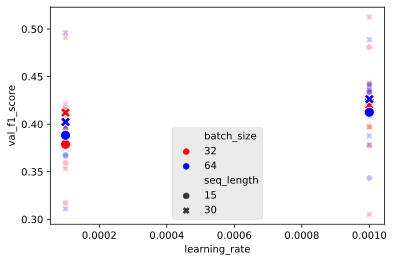

In [27]:
rep_df = pd.DataFrame(linear_param_fit.report)
rep_df['val_accuracy'] = rep_df.class_rep_val.apply(pd.Series)['accuracy']
rep_df['val_precision'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['precision']
rep_df['val_recall'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['recall']
rep_df['val_f1_score'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['f1-score']
rep_df.drop(['class_rep_val', 'class_rep_test'], axis=1, inplace=True)

fdict = {'val_accuracy': ['mean', 'std'], 'val_precision': ['mean', 'std'],
         'val_recall': ['mean', 'std'], 'val_f1_score': ['mean', 'std']}
rep_df_stat = rep_df.groupby(['batch_size', 'seq_length', 'learning_rate']).agg(fdict)      
rep_df_stat.reset_index(inplace=True)

fig, ax = plt.subplots()

plt.style.use('ggplot')
sns.scatterplot(data=rep_df, x='learning_rate', y='val_f1_score',
                    hue=rep_df['batch_size'], palette=['red', 'blue'], alpha=0.25,
                    style=rep_df['seq_length'], ax=ax)

sns.scatterplot(data=rep_df_stat, x='learning_rate', y=('val_f1_score', 'mean'),
                    hue='batch_size', palette=['red', 'blue'],
                    style='seq_length', ax=ax, s=100)

#rep_df_stat.plot.scatter(x='learning_rate', y=('val_f1_score', 'mean'), ax=ax, s=100, marker='x')
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h[:-6], labels=l[:-6], loc='lower center')

plt.show()

Instances Train: 690  Test: 192  Validation: 77
Model: "linear_model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_40 (Flatten)        (64, 480)                 0         
                                                                 
 layer_normalization_40 (Lay  (64, 480)                960       
 erNormalization)                                                
                                                                 
 dense_40 (Dense)            (64, 17)                  8177      
                                                                 
Total params: 9,137
Trainable params: 9,137
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
7095/7095 [==============================] - 159s 22ms/step - loss: 1.2580 - categorical_accuracy: 0.6088 - precision_40: 0.1208 - recall_40: 0.9416 - f1_score: 0.1702 - val_loss: 1.1

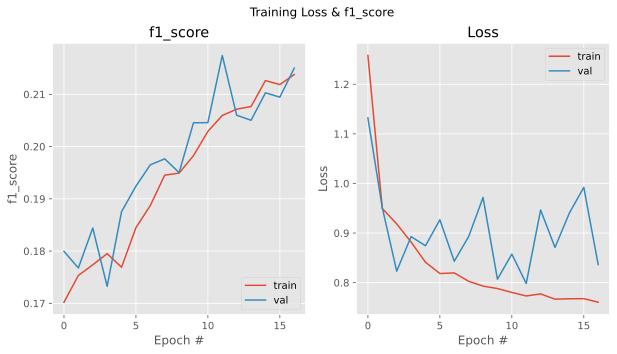

Val Classification Report
              precision    recall  f1-score   support

           0       0.26      0.12      0.16       880
           1       0.81      0.82      0.81      4200
           2       0.95      1.00      0.97       360
           3       0.80      0.14      0.24      6030
           5       0.99      0.90      0.94     14062
           6       0.98      0.99      0.99      5100
           7       0.29      0.59      0.39        87
           8       0.81      0.95      0.88      1148
         101       0.76      0.74      0.75      6000
         102       0.57      0.98      0.72        60
         105       0.75      0.95      0.84      2038
         106       0.73      0.91      0.81      2040
         107       0.17      0.68      0.28      1210
         108       0.29      0.59      0.39      1792

    accuracy                           0.75     45007
   macro avg       0.65      0.74      0.65     45007
weighted avg       0.82      0.75      0.75     45007


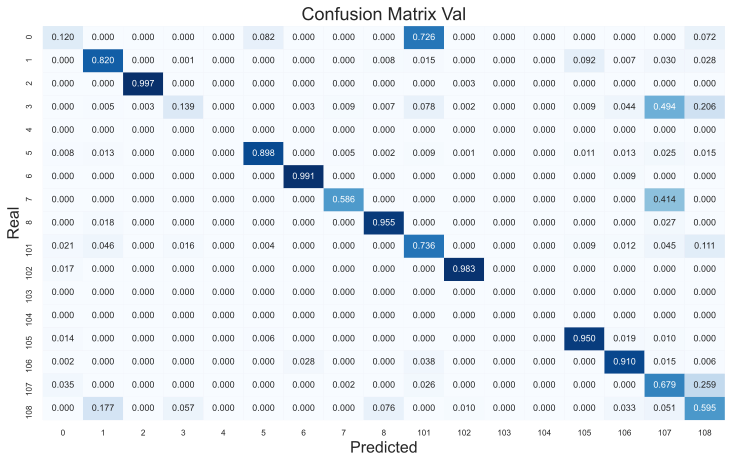

Test Classification Report
              precision    recall  f1-score   support

           0       0.24      0.46      0.32      2424
           1       0.68      0.84      0.75      9129
           2       0.61      0.96      0.74      1080
           3       0.79      0.23      0.35     13674
           5       0.92      0.83      0.87     35281
           6       0.99      0.97      0.98     12867
           7       0.02      0.01      0.02       217
           8       0.82      0.95      0.88      2163
         101       0.70      0.40      0.51     19782
         102       0.26      0.96      0.41       180
         105       0.78      0.95      0.85      5199
         106       0.67      0.93      0.78      5193
         107       0.13      0.47      0.20      3099
         108       0.29      0.60      0.39      4557

    accuracy                           0.69    114845
   macro avg       0.56      0.68      0.58    114845
weighted avg       0.77      0.69      0.69    114845

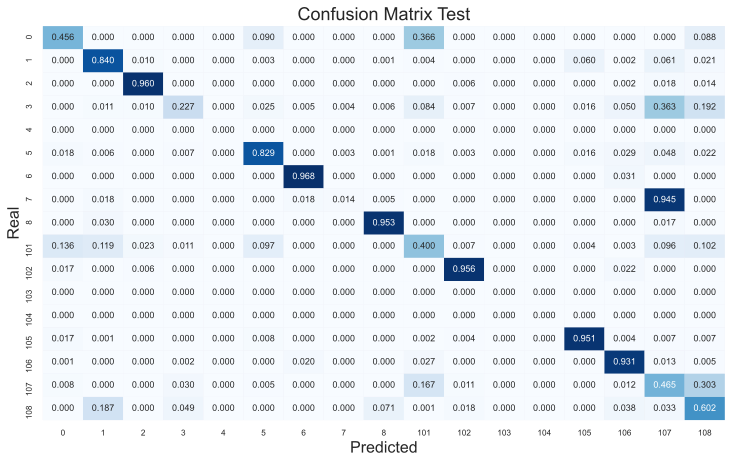

All Data Classification Report
              precision    recall  f1-score   support

           0       0.40      0.46      0.43     14210
           1       0.72      0.88      0.79     48336
           2       0.75      0.98      0.85      5760
           3       0.76      0.19      0.30     68980
           5       0.96      0.85      0.90    176014
           6       0.97      0.97      0.97     64434
           7       0.66      0.72      0.69      1801
           8       0.76      0.96      0.85     10059
         101       0.69      0.53      0.60     86657
         102       0.35      0.97      0.52       960
         105       0.83      0.95      0.88     25926
         106       0.69      0.92      0.79     25866
         107       0.31      0.66      0.42     34072
         108       0.31      0.61      0.41     23961

    accuracy                           0.72    587036
   macro avg       0.66      0.76      0.67    587036
weighted avg       0.78      0.72      0.72    58

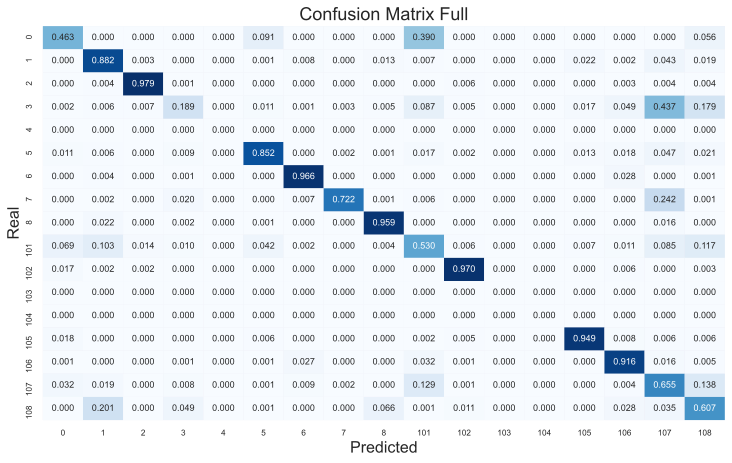

model weights saved in linear_model_40_batch_size_64-seq_length_30-2022-09-08T16_28_24.h5
Wall time: 26min 30s


In [28]:
%%time

train_df, test_df, val_df = dset.split(real=False, simul=True, drawn=True, test_size=0.2, val_size=0.1)

tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

linear_model = kmodel('LinearModel', LinearModel, flist0, 'class', categories, 64, 30, 
                      train_df, val_df, test_df, 'D:/datatmp', reset_ts=False, class_bal=True)

linear_model.compile_and_fit(max_epochs=50, patience=5, lr=0.001)

linear_model.save()

<table><tr>
<td> 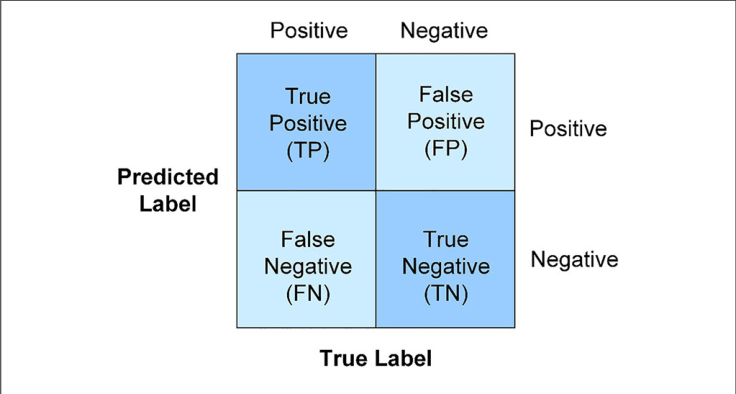 </td>
<td> 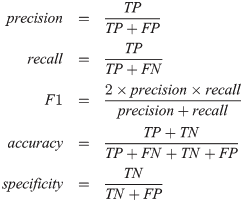 </td>
</tr></table>


# DNN model

In [29]:
class DNNModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.flatten = layers.Flatten()
    self.norm = layers.LayerNormalization()
    self.dense0 = layers.Dense(units=256, activation='relu')
    self.drop0 = layers.Dropout(0.1, seed=200560)
    self.dense1 = layers.Dense(units=128, activation='relu')
    self.drop1 = layers.Dropout(0.1, seed=200560)
    self.dense2 = layers.Dense(units=64, activation='relu')
    self.drop2 = layers.Dropout(0.1, seed=200560)
    self.dense3 = layers.Dense(units=17, activation='relu')
    self.softmax = layers.Softmax()

  def call(self, inputs, training=False):
    x = self.flatten(inputs)
    x = self.norm(x)
    x = self.dense0(x)
    if training:
        x = self.drop0(x, training=training)
    x = self.dense1(x)
    if training:
        x = self.drop1(x, training=training)
    x = self.dense2(x)
    if training:
        x = self.drop2(x, training=training)
    x = self.dense3(x)
    return self.softmax(x)

Instances Train: 1425  Test: 397  Validation: 159
Model: "dnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 480)                 0         
                                                                 
 layer_normalization (LayerN  (64, 480)                960       
 ormalization)                                                   
                                                                 
 dense (Dense)               (64, 256)                 123136    
                                                                 
 dropout (Dropout)           (64, 256)                 0         
                                                                 
 dense_1 (Dense)             (64, 128)                 32896     
                                                                 
 dropout_1 (Dropout)         (64, 128)                 0         
       

9819/9819 [==============================] - 98s 10ms/step - loss: 0.3193 - categorical_accuracy: 0.8599 - precision: 0.9383 - recall: 0.8550 - f1_score: 0.7467 - val_loss: 0.4601 - val_categorical_accuracy: 0.8397 - val_precision: 0.9255 - val_recall: 0.8369 - val_f1_score: 0.6772
Epoch 23/50
9819/9819 [==============================] - 97s 10ms/step - loss: 0.3163 - categorical_accuracy: 0.8614 - precision: 0.9396 - recall: 0.8568 - f1_score: 0.7491 - val_loss: 0.4521 - val_categorical_accuracy: 0.8444 - val_precision: 0.9308 - val_recall: 0.8421 - val_f1_score: 0.6812
Epoch 24/50
9819/9819 [==============================] - 96s 10ms/step - loss: 0.3142 - categorical_accuracy: 0.8626 - precision: 0.9407 - recall: 0.8582 - f1_score: 0.7510 - val_loss: 0.4462 - val_categorical_accuracy: 0.8458 - val_precision: 0.9333 - val_recall: 0.8426 - val_f1_score: 0.6821
Epoch 25/50
9819/9819 [==============================] - 100s 10ms/step - loss: 0.3125 - categorical_accuracy: 0.8634 - precisi

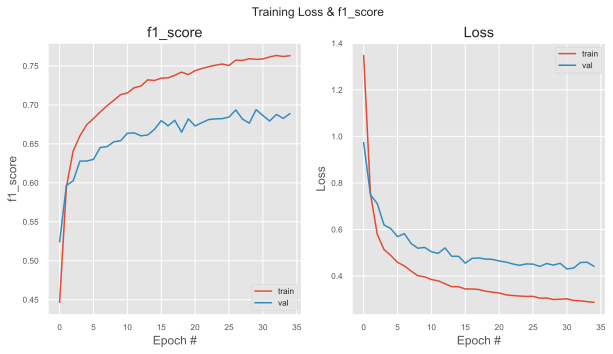

Val Classification Report
              precision    recall  f1-score   support

           0       0.68      0.91      0.78     12978
           1       0.78      0.99      0.87      3780
           2       1.00      0.97      0.98       360
           3       0.99      0.95      0.97      4650
           4       0.80      0.91      0.85      2539
           5       0.99      0.98      0.99     14123
           6       0.00      0.00      0.00      5400
           7       0.00      0.00      0.00        14
           8       0.90      0.99      0.95       748
         101       0.95      0.83      0.89      7435
         102       0.97      0.81      0.89        81
         105       0.88      0.99      0.93      2004
         106       0.84      1.00      0.91      2160
         107       0.55      0.72      0.62       635
         108       0.99      0.95      0.97      1772

    accuracy                           0.85     58679
   macro avg       0.75      0.80      0.77     58679


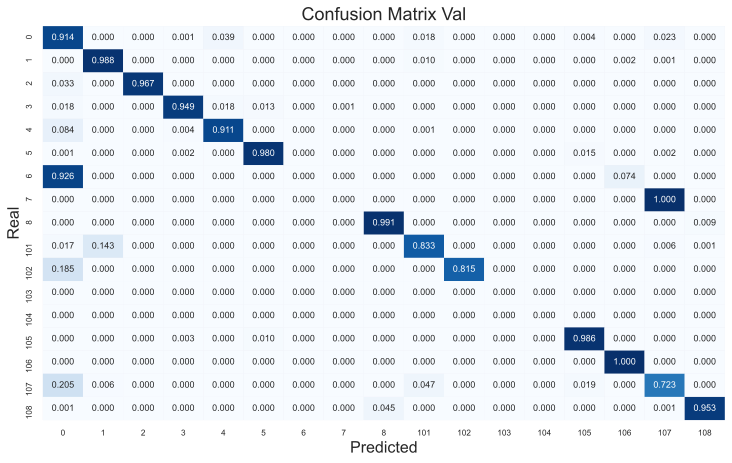

Test Classification Report
              precision    recall  f1-score   support

           0       0.69      0.88      0.77     33789
           1       0.83      0.98      0.90      9399
           2       0.90      1.00      0.95      1097
           3       0.99      0.93      0.96     15400
           4       0.75      0.97      0.84      6246
           5       1.00      0.97      0.98     35960
           6       0.00      0.00      0.00     12914
           7       0.51      1.00      0.68        87
           8       0.81      0.99      0.89      1746
         101       0.92      0.86      0.89     18727
         102       0.71      0.72      0.72       452
         105       0.82      0.98      0.89      5151
         106       0.83      0.99      0.90      5173
         107       0.91      0.99      0.95     11580
         108       0.99      0.92      0.95      4974

    accuracy                           0.86    162695
   macro avg       0.78      0.88      0.82    162695

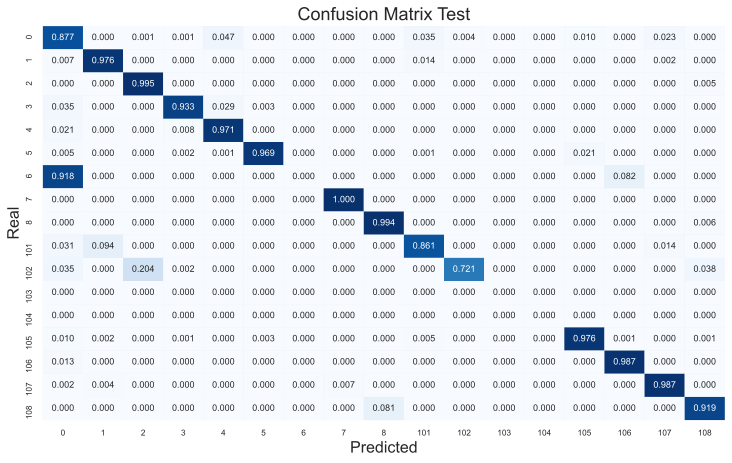

All Data Classification Report
              precision    recall  f1-score   support

           0       0.70      0.92      0.80    164820
           1       0.87      0.98      0.92     48436
           2       0.93      1.00      0.96      6042
           3       0.99      0.98      0.99     77554
           4       0.84      0.98      0.91     31211
           5       1.00      0.98      0.99    176186
           6       0.00      0.00      0.00     64648
           7       0.66      0.99      0.79      1815
           8       0.90      0.99      0.94     10059
         101       0.95      0.89      0.92     87937
         102       0.78      0.82      0.80      2339
         105       0.89      0.99      0.94     31150
         106       0.84      1.00      0.91     25955
         107       0.91      0.96      0.93     38338
         108       0.99      0.95      0.97     23961

    accuracy                           0.88    790451
   macro avg       0.82      0.90      0.85    79

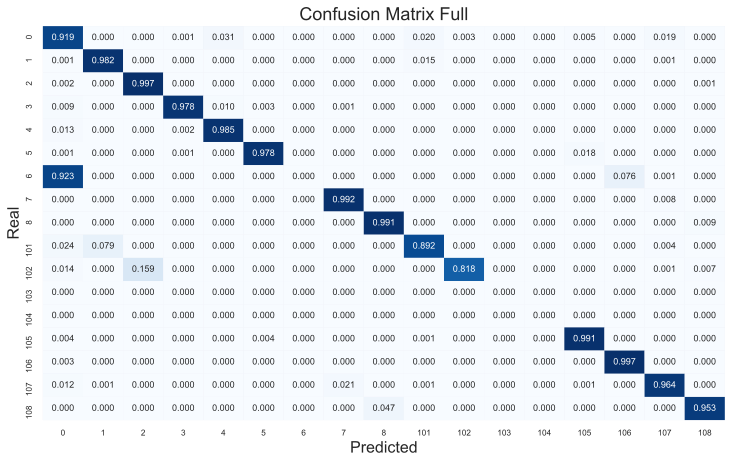

model weights saved in dnn_model_batch_size_64-seq_length_30-2022-09-08T17_33_24.h5
Wall time: 1h 2min 36s


In [30]:
%%time

train_df, test_df, val_df = dset.split(real=True, simul=True, drawn=True, test_size=0.2, val_size=0.1)

tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

dnn_model = kmodel('DNNModel', DNNModel, flist0, 'class', categories, 64, 30, 
                      train_df, val_df, test_df, 'D:/datatmp', reset_ts=False, class_bal=True)

dnn_model.compile_and_fit(max_epochs=50, patience=5, lr=0.0001)

dnn_model.save()

# RNN model

In [31]:
class RNNModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.lstm = layers.LSTM(128, return_sequences=False, dropout=0.15, name='lstm')
    self.dense1 = layers.Dense(17, activation='relu', name='dense1')
    self.softmax = layers.Softmax(name='softmax')
    return

  def call(self, inputs, training=False):
    x = self.lstm(inputs, training=training)
    x = self.dense1(x)
    return self.softmax(x)

Instances Train: 1425  Test: 397  Validation: 159
Model: "rnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (64, 128)                 74240     
                                                                 
 dense1 (Dense)              (64, 17)                  2193      
                                                                 
 softmax (Softmax)           (64, 17)                  0         
                                                                 
Total params: 76,433
Trainable params: 76,433
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
9819/9819 [==============================] - 114s 11ms/step - loss: 1.3668 - categorical_accuracy: 0.6274 - precision: 0.7926 - recall: 0.5006 - f1_score: 0.4497 - val_loss: 0.5997 - val_categorical_accuracy: 0.7978 - val_precision: 0.8589 - val_recal

Epoch 26/50
9819/9819 [==============================] - 102s 10ms/step - loss: 0.2451 - categorical_accuracy: 0.9730 - precision: 0.9764 - recall: 0.9724 - f1_score: 0.7925 - val_loss: 0.2174 - val_categorical_accuracy: 0.9425 - val_precision: 0.9448 - val_recall: 0.9412 - val_f1_score: 0.7562
Epoch 27/50
9819/9819 [==============================] - 105s 11ms/step - loss: 0.2487 - categorical_accuracy: 0.9728 - precision: 0.9763 - recall: 0.9723 - f1_score: 0.7936 - val_loss: 0.2401 - val_categorical_accuracy: 0.9384 - val_precision: 0.9404 - val_recall: 0.9373 - val_f1_score: 0.7556
Epoch 28/50
9819/9819 [==============================] - 102s 10ms/step - loss: 0.2447 - categorical_accuracy: 0.9742 - precision: 0.9776 - recall: 0.9735 - f1_score: 0.7952 - val_loss: 0.2352 - val_categorical_accuracy: 0.9388 - val_precision: 0.9408 - val_recall: 0.9371 - val_f1_score: 0.7515
Epoch 29/50
9819/9819 [==============================] - 102s 10ms/step - loss: 0.2448 - categorical_accuracy: 0

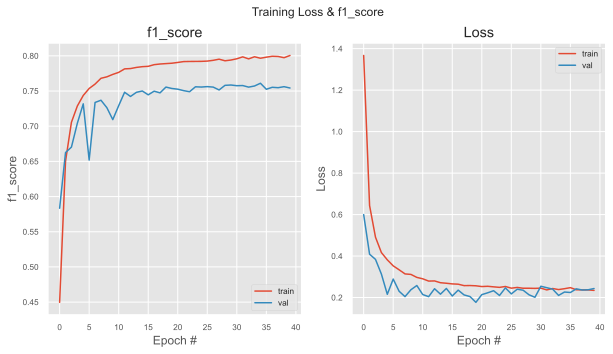

Val Classification Report
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     12978
           1       0.84      0.98      0.90      3780
           2       1.00      0.98      0.99       360
           3       0.99      0.93      0.96      4650
           4       0.83      0.88      0.86      2539
           5       0.98      0.98      0.98     14123
           6       1.00      0.98      0.99      5400
           7       0.00      0.00      0.00        14
           8       0.90      0.98      0.94       748
         101       0.92      0.90      0.91      7435
         102       0.65      0.98      0.78        81
         105       0.87      0.98      0.92      2004
         106       0.96      0.99      0.98      2160
         107       0.77      0.85      0.80       635
         108       0.98      0.95      0.97      1772

    accuracy                           0.95     58679
   macro avg       0.84      0.89      0.86     58679


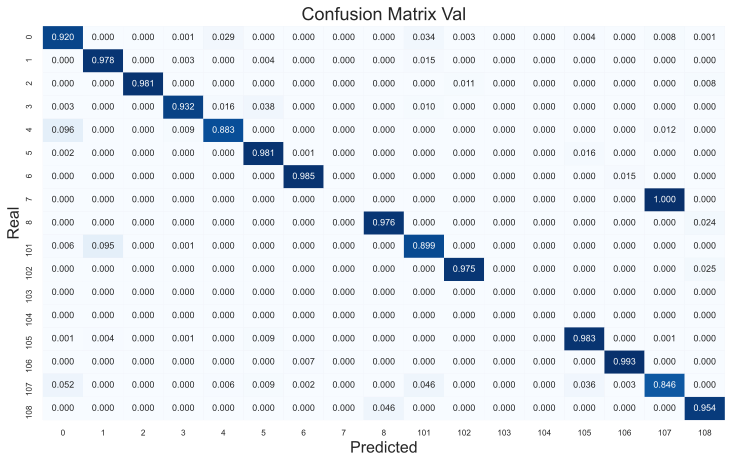

Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     33789
           1       0.88      0.93      0.90      9399
           2       0.94      0.95      0.95      1097
           3       0.99      0.98      0.98     15400
           4       0.81      0.99      0.89      6246
           5       0.99      0.97      0.98     35960
           6       0.99      0.98      0.98     12914
           7       0.00      0.00      0.00        87
           8       0.81      0.99      0.89      1746
         101       0.93      0.91      0.92     18727
         102       0.74      0.77      0.75       452
         105       0.85      0.97      0.91      5151
         106       0.95      0.97      0.96      5173
         107       0.95      0.99      0.97     11580
         108       0.98      0.92      0.95      4974

    accuracy                           0.95    162695
   macro avg       0.85      0.88      0.87    162695

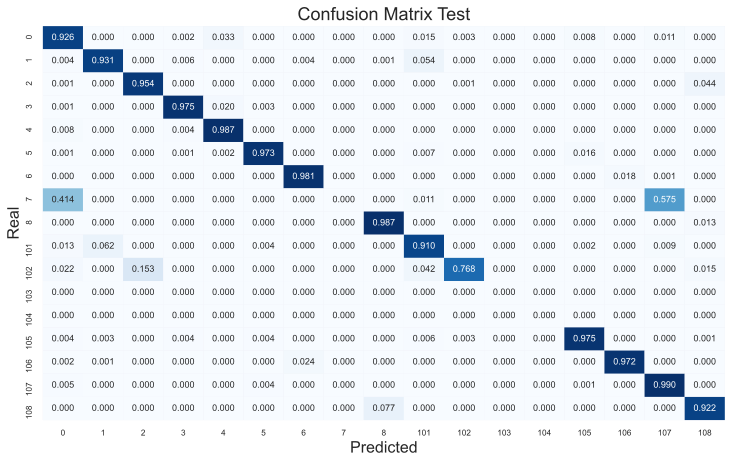

All Data Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    164820
           1       0.93      0.97      0.95     48436
           2       0.97      0.98      0.98      6042
           3       1.00      0.99      0.99     77554
           4       0.93      0.99      0.96     31211
           5       1.00      0.98      0.99    176186
           6       0.99      0.98      0.99     64648
           7       0.00      0.00      0.00      1815
           8       0.91      0.99      0.95     10059
         101       0.95      0.95      0.95     87937
         102       0.78      0.92      0.84      2339
         105       0.91      0.99      0.95     31150
         106       0.96      0.98      0.97     25955
         107       0.97      0.99      0.98     38338
         108       0.99      0.96      0.97     23961

    accuracy                           0.97    790451
   macro avg       0.89      0.91      0.90    79

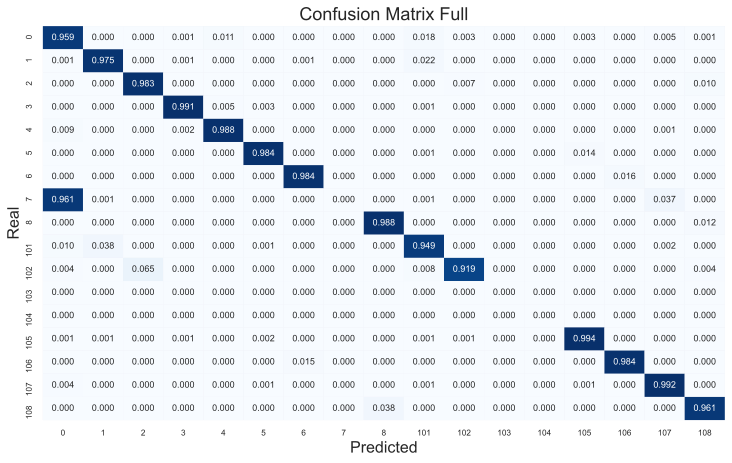

model weights saved in rnn_model_batch_size_64-seq_length_30-2022-09-08T19_48_42.h5
Wall time: 1h 13min 11s


In [32]:
%%time

train_df, test_df, val_df = dset.split(real=True, simul=True, drawn=True, test_size=0.2, val_size=0.1)

tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

rnn_model = kmodel('RNNModel', RNNModel, flist0, 'class', categories, 64, 30, 
                      train_df, val_df, test_df, 'D:/datatmp', reset_ts=False, class_bal=True)

rnn_model.compile_and_fit(max_epochs=50, patience=5, lr=0.001)

rnn_model.save()

# CNN model

In [10]:
class CNNModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.norm = layers.LayerNormalization()
    self.conv1 = layers.Conv1D(filters=128, kernel_size=2, padding="same", activation='relu', name='conv1')
    self.MP1 = layers.MaxPooling1D(pool_size=2, name='MP1')
    self.drop1 = layers.Dropout(0.2, seed=200560, name='drop1')
    
    self.conv2 = layers.Conv1D(filters=128, kernel_size=2, padding="same", activation='relu', name='conv2')
    self.MP2 = layers.MaxPooling1D(pool_size=2, name='MP2')
    self.drop2 = layers.Dropout(0.2, seed=200560, name='drop2')
    
    self.conv3 = layers.Conv1D(filters=128, kernel_size=2, padding="same", activation='relu', name='conv3')
    self.MP3 = layers.MaxPooling1D(pool_size=2, name='MP3')
    self.drop3 = layers.Dropout(0.2, seed=200560, name='drop3')
    
    self.flatten = layers.Flatten()
    
    self.dense = layers.Dense(17, activation="relu", name='dense')
    self.softmax = layers.Softmax()
    return 

  def call(self, inputs, training=False):
    x = self.norm(inputs)
    x = self.conv1(x)
    x = self.MP1(x)
    x = self.drop1(x, training=training)
    
    x = self.conv2(x)
    x = self.MP2(x)
    x = self.drop2(x, training=training)
    
    x = self.conv3(x)
    x = self.MP3(x)
    x = self.drop3(x, training=training)
    
    x = self.flatten(x)
    
    x = self.dense(x)
    
    return self.softmax(x)

Instances Train: 1425  Test: 397  Validation: 159
Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization (LayerN  (64, 30, 16)             32        
 ormalization)                                                   
                                                                 
 conv1 (Conv1D)              (64, 30, 128)             4224      
                                                                 
 MP1 (MaxPooling1D)          (64, 15, 128)             0         
                                                                 
 drop1 (Dropout)             (64, 15, 128)             0         
                                                                 
 conv2 (Conv1D)              (64, 15, 128)             32896     
                                                                 
 MP2 (MaxPooling1D)          (64, 7, 128)              0         
       

9819/9819 [==============================] - 110s 11ms/step - loss: 0.3016 - categorical_accuracy: 0.9431 - precision: 0.9493 - recall: 0.9389 - f1_score: 0.7673 - val_loss: 0.2094 - val_categorical_accuracy: 0.9267 - val_precision: 0.9325 - val_recall: 0.9175 - val_f1_score: 0.7286
Epoch 22/50
9819/9819 [==============================] - 112s 11ms/step - loss: 0.3021 - categorical_accuracy: 0.9452 - precision: 0.9512 - recall: 0.9416 - f1_score: 0.7698 - val_loss: 0.1704 - val_categorical_accuracy: 0.9418 - val_precision: 0.9455 - val_recall: 0.9344 - val_f1_score: 0.7419
Epoch 23/50
9819/9819 [==============================] - 112s 11ms/step - loss: 0.2990 - categorical_accuracy: 0.9471 - precision: 0.9529 - recall: 0.9436 - f1_score: 0.7689 - val_loss: 0.1904 - val_categorical_accuracy: 0.9364 - val_precision: 0.9399 - val_recall: 0.9297 - val_f1_score: 0.7388
Epoch 24/50
9819/9819 [==============================] - 107s 11ms/step - loss: 0.2935 - categorical_accuracy: 0.9483 - prec

Epoch 49/50
9819/9819 [==============================] - 110s 11ms/step - loss: 0.2598 - categorical_accuracy: 0.9640 - precision: 0.9682 - recall: 0.9628 - f1_score: 0.7866 - val_loss: 0.1655 - val_categorical_accuracy: 0.9473 - val_precision: 0.9504 - val_recall: 0.9450 - val_f1_score: 0.7470
Epoch 50/50
9819/9819 [==============================] - 111s 11ms/step - loss: 0.2574 - categorical_accuracy: 0.9652 - precision: 0.9693 - recall: 0.9640 - f1_score: 0.7878 - val_loss: 0.1595 - val_categorical_accuracy: 0.9404 - val_precision: 0.9445 - val_recall: 0.9380 - val_f1_score: 0.7426


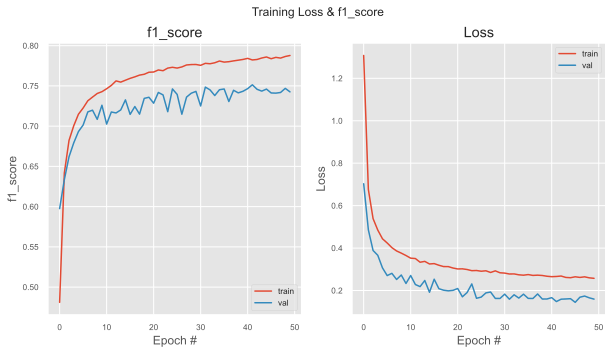

Val Classification Report
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     12978
           1       0.84      0.97      0.90      3780
           2       1.00      0.97      0.98       360
           3       0.99      0.96      0.97      4650
           4       0.90      0.88      0.89      2539
           5       1.00      0.98      0.99     14123
           6       1.00      0.98      0.99      5400
           7       0.00      0.00      0.00        14
           8       0.95      0.97      0.96       748
         101       0.89      0.90      0.90      7435
         102       0.52      0.83      0.64        81
         105       0.86      0.98      0.92      2004
         106       0.94      1.00      0.97      2160
         107       0.67      0.89      0.76       635
         108       0.98      0.98      0.98      1772

    accuracy                           0.95     58679
   macro avg       0.83      0.88      0.85     58679


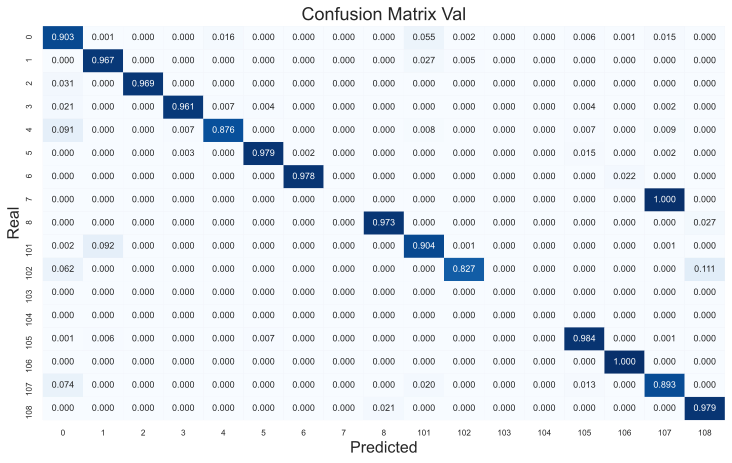

Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     33789
           1       0.90      0.89      0.90      9399
           2       0.93      0.99      0.96      1097
           3       0.99      0.98      0.99     15400
           4       0.85      0.98      0.91      6246
           5       1.00      0.98      0.99     35960
           6       0.99      0.97      0.98     12914
           7       0.00      0.00      0.00        87
           8       0.85      0.98      0.91      1746
         101       0.87      0.93      0.90     18727
         102       0.66      0.63      0.65       452
         105       0.82      0.97      0.89      5151
         106       0.92      0.98      0.95      5173
         107       0.89      1.00      0.94     11580
         108       0.98      0.94      0.96      4974

    accuracy                           0.95    162695
   macro avg       0.84      0.87      0.86    162695

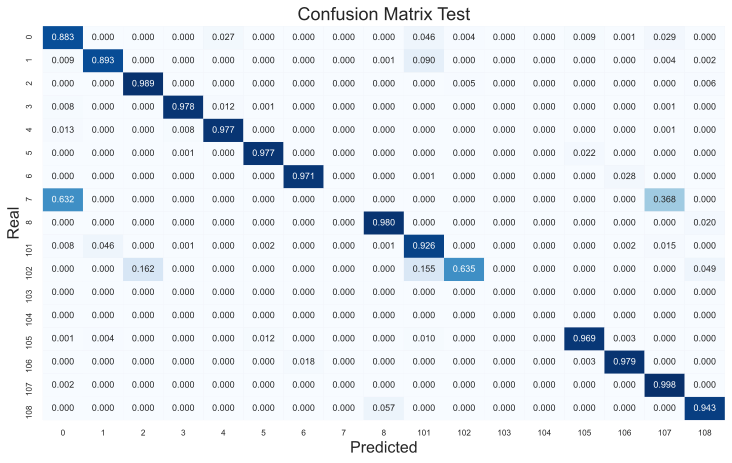

All Data Classification Report
              precision    recall  f1-score   support

           0       0.98      0.92      0.95    164820
           1       0.94      0.94      0.94     48436
           2       0.98      0.99      0.98      6042
           3       1.00      0.99      0.99     77554
           4       0.93      0.98      0.96     31211
           5       1.00      0.98      0.99    176186
           6       1.00      0.97      0.98     64648
           7       0.00      0.00      0.00      1815
           8       0.94      0.98      0.96     10059
         101       0.90      0.95      0.93     87937
         102       0.69      0.90      0.78      2339
         105       0.89      0.99      0.94     31150
         106       0.93      0.99      0.96     25955
         107       0.91      1.00      0.95     38338
         108       0.99      0.97      0.98     23961

    accuracy                           0.96    790451
   macro avg       0.87      0.90      0.89    79

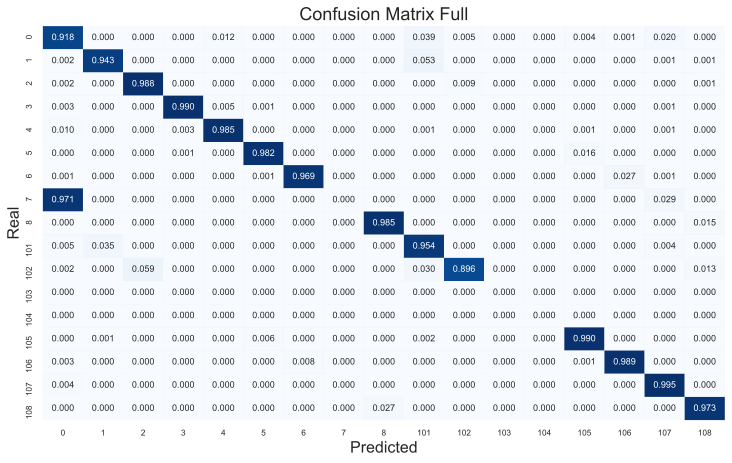

model weights saved in cnn_model_batch_size_64-seq_length_30-2022-09-08T06_49_06.h5
Wall time: 1h 35min 59s


In [13]:
%%time

train_df, test_df, val_df = dset.split(real=True, simul=True, drawn=True, test_size=0.2, val_size=0.1)

tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

cnn_model = kmodel('CNNModel', CNNModel, flist0, 'class', categories, 64, 30, 
                      train_df, val_df, test_df, 'D:/datatmp', reset_ts=False, class_bal=True)

cnn_model.compile_and_fit(max_epochs=50, patience=10, lr=0.0001)

cnn_model.save()

# Mixed model

In [35]:
class MixedModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    
    # CNN
    self.norm = layers.LayerNormalization(name='CNN_norm')
    self.conv1 = layers.Conv1D(filters=128, kernel_size=2, padding="same", activation='relu', name='conv1')
    self.MP1 = layers.MaxPooling1D(pool_size=2, name='MP1')
    self.drop1 = layers.Dropout(0.2, seed=200560, name='drop1')
    
    self.conv2 = layers.Conv1D(filters=128, kernel_size=2, padding="same", activation='relu', name='conv2')
    self.MP2 = layers.MaxPooling1D(pool_size=2, name='MP2')
    self.drop2 = layers.Dropout(0.2, seed=200560, name='drop2')
    
    self.conv3 = layers.Conv1D(filters=128, kernel_size=2, padding="same", activation='relu', name='conv3')
    self.MP3 = layers.MaxPooling1D(pool_size=2, name='MP3')
    self.drop3 = layers.Dropout(0.2, seed=200560, name='drop3')
    
    self.flatten = layers.Flatten(name='CNN_flatten')
    
    #RNN
    self.lstm = layers.LSTM(128, return_sequences=False, dropout=0.15, name='lstm')

    #Dense
    self.dense = layers.Dense(17, activation="relu", name='dense')
    self.softmax = layers.Softmax(name='softmax')

  def call(self, inputs, training=False):
    x = self.norm(inputs)
    x = self.conv1(x)
    x = self.MP1(x)
    x = self.drop1(x, training=training)
    
    x = self.conv2(x)
    x = self.MP2(x)
    x = self.drop2(x, training=training)
    
    x = self.conv3(x)
    x = self.MP3(x)
    x = self.drop3(x, training=training)
    
    x = self.flatten(x)
    
    y = self.lstm(inputs, training=training)

    z = tf.concat([x, y], 1)
    z = self.dense(z)
    return self.softmax(z)

Instances Train: 1425  Test: 397  Validation: 159
Model: "mixed_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_norm (LayerNormalizatio  (64, 30, 16)             32        
 n)                                                              
                                                                 
 conv1 (Conv1D)              (64, 30, 128)             4224      
                                                                 
 MP1 (MaxPooling1D)          (64, 15, 128)             0         
                                                                 
 drop1 (Dropout)             (64, 15, 128)             0         
                                                                 
 conv2 (Conv1D)              (64, 15, 128)             32896     
                                                                 
 MP2 (MaxPooling1D)          (64, 7, 128)              0         
     

9819/9819 [==============================] - 152s 15ms/step - loss: 0.2749 - categorical_accuracy: 0.9586 - precision: 0.9633 - recall: 0.9566 - f1_score: 0.7817 - val_loss: 0.1589 - val_categorical_accuracy: 0.9437 - val_precision: 0.9468 - val_recall: 0.9412 - val_f1_score: 0.7384
Epoch 21/100
9819/9819 [==============================] - 160s 16ms/step - loss: 0.2747 - categorical_accuracy: 0.9597 - precision: 0.9644 - recall: 0.9577 - f1_score: 0.7815 - val_loss: 0.1510 - val_categorical_accuracy: 0.9483 - val_precision: 0.9520 - val_recall: 0.9445 - val_f1_score: 0.7385
Epoch 22/100
9819/9819 [==============================] - 150s 15ms/step - loss: 0.2730 - categorical_accuracy: 0.9603 - precision: 0.9649 - recall: 0.9581 - f1_score: 0.7817 - val_loss: 0.1769 - val_categorical_accuracy: 0.9418 - val_precision: 0.9461 - val_recall: 0.9361 - val_f1_score: 0.7378
Epoch 23/100
9819/9819 [==============================] - 151s 15ms/step - loss: 0.2701 - categorical_accuracy: 0.9624 - p

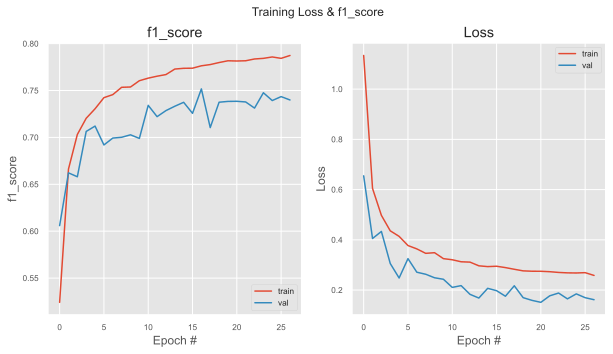

Val Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     12978
           1       0.81      0.98      0.89      3780
           2       1.00      0.97      0.98       360
           3       0.94      0.97      0.95      4650
           4       0.86      0.90      0.88      2539
           5       0.99      0.95      0.97     14123
           6       0.99      0.96      0.98      5400
           7       0.00      0.00      0.00        14
           8       0.92      0.98      0.95       748
         101       0.98      0.85      0.91      7435
         102       0.59      0.99      0.74        81
         105       0.81      0.99      0.89      2004
         106       0.90      1.00      0.95      2160
         107       0.64      0.82      0.72       635
         108       0.99      0.96      0.98      1772

    accuracy                           0.94     58679
   macro avg       0.82      0.88      0.85     58679


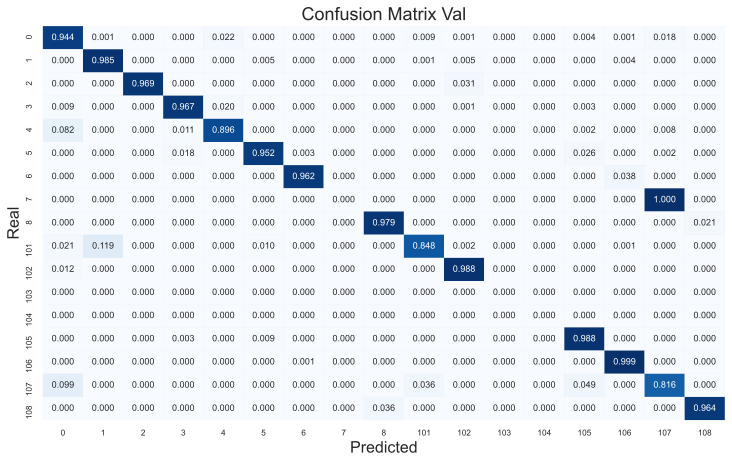

Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     33789
           1       0.87      0.96      0.92      9399
           2       0.95      1.00      0.97      1097
           3       0.98      0.99      0.98     15400
           4       0.83      0.97      0.89      6246
           5       1.00      0.96      0.98     35960
           6       0.99      0.96      0.97     12914
           7       0.00      0.00      0.00        87
           8       0.85      0.98      0.91      1746
         101       0.97      0.87      0.91     18727
         102       0.75      0.75      0.75       452
         105       0.71      0.98      0.83      5151
         106       0.90      0.98      0.94      5173
         107       0.92      1.00      0.96     11580
         108       0.98      0.94      0.96      4974

    accuracy                           0.95    162695
   macro avg       0.84      0.88      0.86    162695

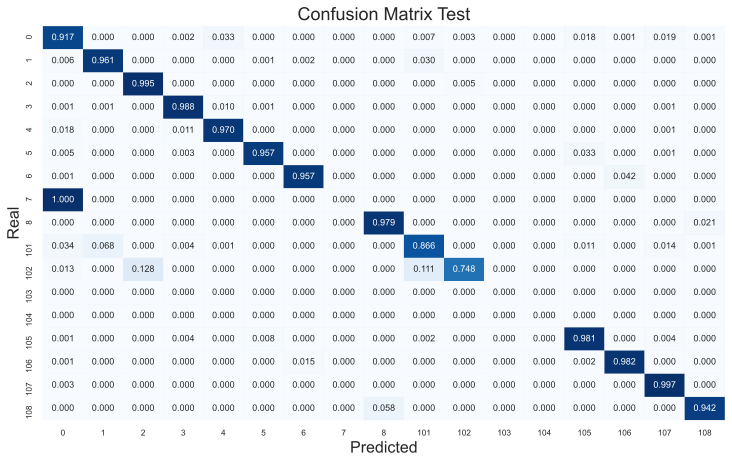

All Data Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95    164820
           1       0.89      0.97      0.93     48436
           2       0.97      0.98      0.98      6042
           3       0.97      0.99      0.98     77554
           4       0.89      0.98      0.93     31211
           5       1.00      0.96      0.98    176186
           6       1.00      0.96      0.98     64648
           7       0.00      0.00      0.00      1815
           8       0.93      0.97      0.95     10059
         101       0.97      0.89      0.93     87937
         102       0.73      0.92      0.81      2339
         105       0.82      1.00      0.90     31150
         106       0.90      0.99      0.95     25955
         107       0.92      0.99      0.95     38338
         108       0.98      0.97      0.98     23961

    accuracy                           0.95    790451
   macro avg       0.86      0.90      0.88    79

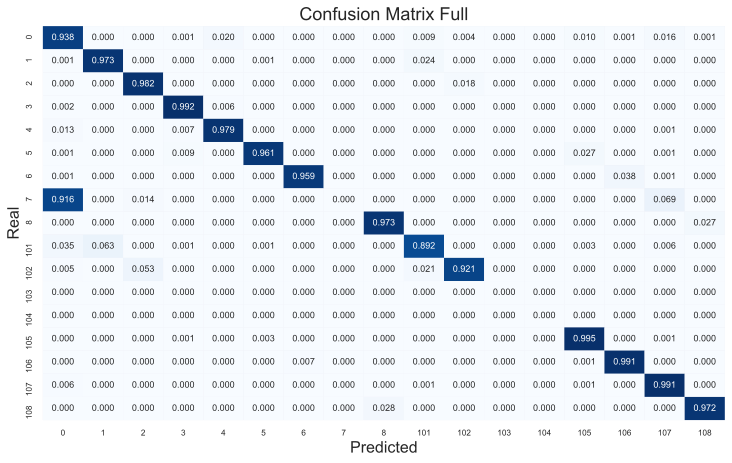

Wall time: 1h 15min


In [37]:
%%time

train_df, test_df, val_df = dset.split(real=True, simul=True, drawn=True, test_size=0.2, val_size=0.1)

tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

mixed_model = kmodel('MixedModel', MixedModel, flist0, 'class', categories, 64, 30, 
                      train_df, val_df, test_df, 'D:/datatmp', reset_ts=True, class_bal=True)

mixed_model.compile_and_fit(max_epochs=100, patience=10, lr=0.0001)


# Ancillary

In [ ]:
dset_g = CustomDataGen(dset.drawn, flist0, 'class', categories, 64, 30, 'D:\datatmp')
fmodel = kmodel_from_file(RNNModel, (30, 16), 'RNNModel_batch_size_64-seq_length_30-2022-09-03T15_47_05.h5')

In [ ]:
#dset_g.plot(0)
rnn_model.class_rep(dset_g)